# Balanced Risk Set Matching
Zeus D. Elderfield

Link to article: [Balanced Risk Set Matching: Journal of the American Statistical Association](https://doi.org/10.1198/016214501753208573)

## Instructions:
- Read the journal provided.
- Develop a Python implementation of the procedures in the journal.
- Deadline is before premidterm week.

### Import necessary libraries

In [296]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

### Set global variables & seed

In [297]:
np.random.seed(24)

number_of_patients = 200
evaluation_years = 4
evaluation_months = evaluation_years * 12
MAX_MATCHES = 100
BOX_TITLES = ['Baseline', 'At Treatment', '3 Months after Treatment', '6 Months after Treatment']
BOX_LABELS = ['Never/Later Treated', 'Treated']

### Load initial evaluation data upon patient entry

In [298]:
baseline = pd.DataFrame({
    "patient_id": np.arange(0, number_of_patients),
    "gender": np.random.choice(['M', 'F'], number_of_patients),
    "pain": np.random.randint(0, 10, number_of_patients),
    "urgency": np.random.randint(0, 10, number_of_patients),
    "frequency": np.random.randint(0, 20, number_of_patients)
})

baseline.head()

,patient_id,gender,pain,urgency,frequency
0,0,M,1,7,16
1,1,F,1,8,19
2,2,M,8,8,14
3,3,F,3,2,18
4,4,F,5,4,17


### Load evaluation data every 3 months

In [299]:
evaluations = pd.DataFrame()

for patient_id in range(number_of_patients):
    chosen_treatment_time = np.random.choice(list(np.arange(3, evaluation_months + 1, 3)) + [None])
    
    # Evaluate every 3 months up to 4 years
    for month in range(3, evaluation_months + 1, 3):
        pain = np.random.randint(0, 10, 1)
        urgency = np.random.randint(0, 10, 1)
        frequency = np.random.randint(0, 20, 1)
        time_since_entry = month

        if chosen_treatment_time == None or month < chosen_treatment_time:
            time_treated = None
            treated = 0
        else:
            time_treated = chosen_treatment_time
            treated = 1

        evaluations = pd.concat([evaluations, pd.DataFrame({
            'patient_id': patient_id, 
            'pain': pain, 
            'urgency': urgency, 
            'frequency': frequency, 
            'time_since_entry': time_since_entry, 
            'time_treated': time_treated, 
            'treated': treated
        })])

evaluations.groupby('patient_id')[['pain', 'urgency', 'frequency']].mean().head()

,pain,urgency,frequency
patient_id,,,
0,4.6250,5.3750,8.8750
1,5.3750,4.5000,8.5000
2,4.5625,4.5625,7.3750
3,4.3125,5.1250,7.8125
4,3.5000,4.6250,8.3125


### Generate risk sets

In [300]:
risk_sets = {}

for time in evaluations['time_treated'].dropna().unique():
    treated = evaluations[(evaluations['time_since_entry'] == time) & (evaluations['time_treated'] == time)]
    untreated = evaluations[(evaluations['time_since_entry'] == time) & (evaluations['treated'] == 0)]

    risk_sets[time] = (treated, untreated)

risk_sets.keys()

dict_keys([33, 30, 24, 12, 48, 9, 27, 18, 3, 45, 21, 6, 36, 39, 42, 15])

### Generate Binary Variable Functions

In [301]:
def create_bin_var(df, variables):
    binary_vars =defaultdict(list)
    for var in variables:
        # Compute one-third and two-thirds percentiles
        lower_percentile = np.percentile(df[var], 33)
        upper_percentile = np.percentile(df[var], 67)

        # Create binary variables for lower, middle, and upper groups
        binary_lower = (df[var] <= lower_percentile).astype(int)
        binary_middle = ((df[var] > lower_percentile) & (df[var] <= upper_percentile)).astype(int)
        binary_upper = (df[var] > upper_percentile).astype(int)
        
        # Append to binary_vars "x_lower" is already implied if both variables are 0
        binary_vars[f"{var}_middle"].extend(binary_middle)
        binary_vars[f"{var}_upper"].extend(binary_upper)

    # Generate binary DataFrame for each symptom variable
    binary_df = pd.DataFrame(binary_vars)
    return binary_df

### Update risk set 
Update both dataframes to join with their respective baseline features. Additionally, 12 binary variables are added to these dataframes to determine the feature quantile.

In [302]:
new_rs = {}
variables = [
    'pain_current',
    'urgency_current',
    'frequency_current',
    'pain_baseline',
    'urgency_baseline',
    'frequency_baseline'
]

for key, (t, u) in risk_sets.items():
    # Treated DataFrame
    treated = t.merge(baseline, on='patient_id', suffixes=['_current', '_baseline'])
    
    bin_t = create_bin_var(treated, variables)
    treated = pd.concat([treated, bin_t], axis=1)

    # Untreated DataFrame
    untreated = u.merge(baseline, on='patient_id', suffixes=['_current', '_baseline'])

    bin_u = create_bin_var(untreated, variables)
    untreated = pd.concat([untreated, bin_u], axis=1)

    new_rs[key] = (treated, untreated)

list(new_rs.values())[0][0].columns

Index(['patient_id', 'pain_current', 'urgency_current', 'frequency_current',
       'time_since_entry', 'time_treated', 'treated', 'gender',
       'pain_baseline', 'urgency_baseline', 'frequency_baseline',
       'pain_current_middle', 'pain_current_upper', 'urgency_current_middle',
       'urgency_current_upper', 'frequency_current_middle',
       'frequency_current_upper', 'pain_baseline_middle',
       'pain_baseline_upper', 'urgency_baseline_middle',
       'urgency_baseline_upper', 'frequency_baseline_middle',
       'frequency_baseline_upper'],
      dtype='object')

# Matching by Minimum Cost Flow in a Network

### Compute for the different distance between t and u utilizing Mahalanobis

In [303]:
def compute_distance(treated, untreated, covariates):
    treated_matrix = treated[covariates].to_numpy()
    untreated_matrix = untreated[covariates].to_numpy()
    
    return cdist(treated_matrix, untreated_matrix, metric='mahalanobis')

### Store distances and matches as well as avg distance

In [304]:
distance_dict = defaultdict(list)

for key, (t, u) in new_rs.items():
    distance_matrix = compute_distance(t, u, variables)

    for i, row in enumerate(distance_matrix):
        for j, distance in enumerate(row):
            distance_dict[distance].append((int(t['patient_id'].iloc[i]), int(u['patient_id'].iloc[j])))

mcf_avg_distance = sum(distance_dict.keys()) / len(distance_dict.keys())

mcf_avg_distance

np.float64(3.3476209090392515)

### Create matches from Minimum Cost Flow in a Network (top 100)

In [305]:
mcf_matches = [] # Minimum Cost Flow matches
count = 0

for keys in sorted(distance_dict.keys()):
    for match in distance_dict[keys]:
        if count >= MAX_MATCHES:
            break
            
        mcf_matches.append(match)
        count += 1

mcf_matches[:5] # Print first 5 matches

[(189, 156), (54, 67), (98, 13), (174, 172), (168, 5)]

# Balanced Pair Matching

### Compute for sum of K binary variables

In [306]:
def find_sum_bin(series, variables):
    total = 0

    for var in variables:
        total += series.loc[var]

    return total

In [307]:
bpm_matches = []
patient_set = set()
count = 0

var = [
    f"{x}_middle" for x in variables
] + [
    f"{x}_upper" for x in variables
]

for (t, u) in new_rs.values():
    for i in range(t.shape[0]):
        for j in range(u.shape[0]):
            # If balanced
            if count < MAX_MATCHES and find_sum_bin(t.iloc[i], var) == find_sum_bin(u.iloc[j], var):
                t_id = int(t['patient_id'].iloc[i])
                u_id = int(u['patient_id'].iloc[j])

                if t_id not in patient_set and u_id not in patient_set: 
                    bpm_matches.append((t_id, u_id))
                    
                    patient_set.add(t_id)
                    patient_set.add(u_id)
                count += 1

bpm_matches[:5]

[(0, 12), (5, 35), (43, 44), (82, 11), (84, 8)]

# Group DataFrames based on matches

We will be using the matches we found using Balanced Pair Matching:

There will be eight DataFrames:
- Baseline Treated & Untreated
- At Treatment Treated & Untreated
- 3 months after treatment Treated & Untreated 
- 6 months after treatment Treated & Untreated

Features include:

- Pain Score
- Urgency Score
- Nocturnal Frequency
    

In [308]:
def find_dataframes(match):
    x, y = match
    features = ['pain', 'urgency', 'frequency']

    # Getting baseline data
    baseline_match_x = baseline[baseline['patient_id'] == x][features]
    baseline_match_y = baseline[baseline['patient_id'] == y][features]

    features.append('treated')
    
    # Getting on treatment data
    treatment_match_x = evaluations[(evaluations['patient_id'] == x) 
        & (evaluations['time_treated'] == evaluations['time_since_entry'])][features + ['time_since_entry']]

    time_since_entry = treatment_match_x['time_since_entry'].iloc[0] if not treatment_match_x['time_since_entry'].empty else -1
    
    if time_since_entry == -1:
        return ()
    else:
        treatment_match_x = treatment_match_x.drop('time_since_entry', axis=1)

    treatment_match_y = evaluations[(evaluations['patient_id'] == y) 
        & (evaluations['time_since_entry'] == time_since_entry)][features]

    # Getting 3 months after data
    time_since_entry += 3
    
    _3_months_match_x = evaluations[(evaluations['patient_id'] == x) 
        & (evaluations['time_since_entry'] == time_since_entry)][features]
    _3_months_match_y = evaluations[(evaluations['patient_id'] == y) 
        & (evaluations['time_since_entry'] == time_since_entry)][features]

    # Getting 6 months after data
    time_since_entry += 3

    _6_months_match_x = evaluations[(evaluations['patient_id'] == x) 
        & (evaluations['time_since_entry'] == time_since_entry)][features]
    _6_months_match_y = evaluations[(evaluations['patient_id'] == y) 
        & (evaluations['time_since_entry'] == time_since_entry)][features]

    return (
        baseline_match_x, 
        baseline_match_y,
        treatment_match_x,
        treatment_match_y,
        _3_months_match_x,
        _3_months_match_y,
        _6_months_match_x,
        _6_months_match_y
    )

In [309]:
# Initializing DataFrames
dataframes = [pd.DataFrame() for _ in range(8)]

for match in bpm_matches:
    data = find_dataframes(match)

    if len(data) == 0:
        continue
    
    (
        baseline_match_x, 
        baseline_match_y,
        treatment_match_x,
        treatment_match_y,
        _3_months_match_x,
        _3_months_match_y,
        _6_months_match_x,
        _6_months_match_y
    ) = data

    for i in range(len(dataframes)):
        dataframes[i] = pd.concat([dataframes[i], data[i]])

[
    baseline_x,
    baseline_y,
    treatment_x,
    treatment_y,
    _3_month_x,
    _3_month_y,
    _6_month_x,
    _6_month_y
] = dataframes

# Quality of the Matching

### Pain Score

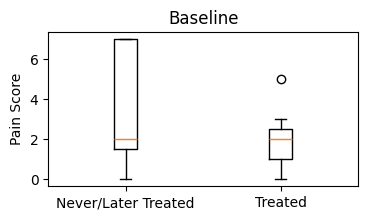

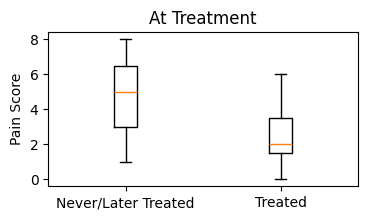

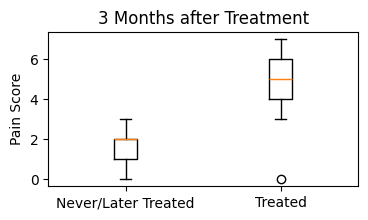

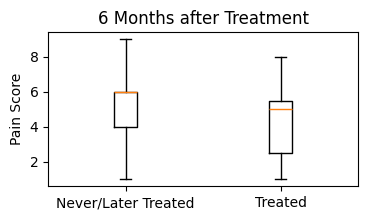

In [315]:
for i in range(0, len(dataframes), 2):    
    fig = plt.figure(i + 1, figsize=(4, 2))
    plt.boxplot([dataframes[i + 1].loc[:, 'pain'], dataframes[i].loc[:, 'pain']])
    plt.title(BOX_TITLES[i // 2])
    plt.ylabel('Pain Score')
    plt.xticks([1, 2], BOX_LABELS)

plt.show()

### Urgency Score

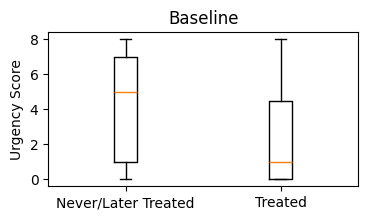

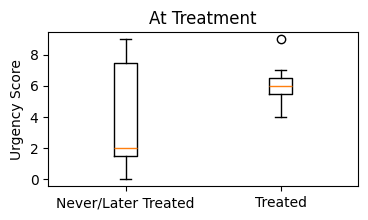

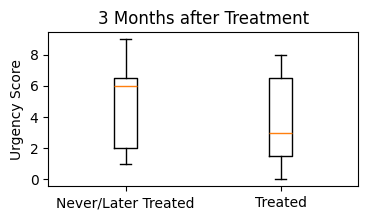

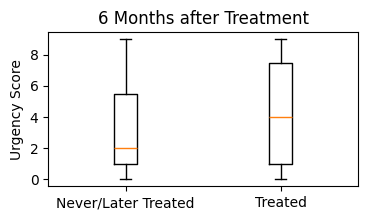

In [314]:
for i in range(0, len(dataframes), 2):    
    fig = plt.figure(i + 1, figsize=(4, 2))
    plt.boxplot([dataframes[i + 1].loc[:, 'urgency'], dataframes[i].loc[:, 'urgency']])
    plt.title(BOX_TITLES[i // 2])
    plt.ylabel('Urgency Score')
    plt.xticks([1, 2], BOX_LABELS)

plt.show()

### Nocturnal Frequency

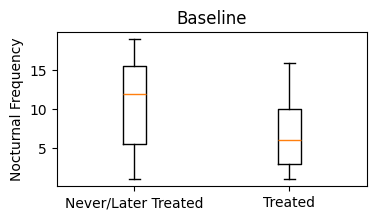

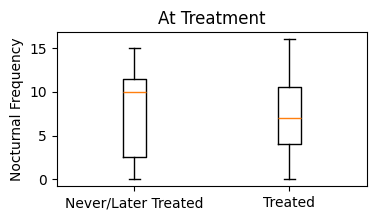

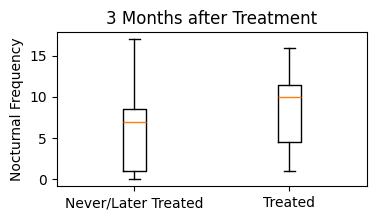

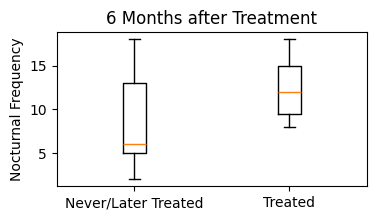

In [316]:
for i in range(0, len(dataframes), 2):    
    fig = plt.figure(i + 1, figsize=(4, 2))
    plt.boxplot([dataframes[i + 1].loc[:, 'frequency'], dataframes[i].loc[:, 'frequency']])
    plt.title(BOX_TITLES[i // 2])
    plt.ylabel('Nocturnal Frequency')
    plt.xticks([1, 2], BOX_LABELS)

plt.show()